#Формирование корпуса документов

##Библиотека

In [ ]:
from urllib.request import urlopen
import json
from typing import List
from requests.models import Response
import requests
import re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
import pymorphy3
import nltk
nltk.download('stopwords')
import asyncio
import aiohttp
import os.path
import pandas as pd
import concurrent.futures
!pip install aiohttp

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pymorphy3
!pip3 install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 86.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=ad2396eb3fdaa4c19d196bcf33c78306e5a408f13722f4e456c17202be1ecc50
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Получение Id вакансий

In [ ]:
def get_ids_by_name(texts: List[str], pages: int = 5) -> List[int]:
  vac_ids = list()

  for text in texts:
    for i in range(pages):
      response = requests.get(f'https://api.hh.ru/vacancies?text={text}&page={i}&per_page=100').content
      data_json = json.loads(response)
      for item in data_json['items']:
        id = int(item['id'])
        if id not in vac_ids:
          vac_ids.append(id)

  return vac_ids

In [ ]:
name_vac = get_ids_by_name(["мобильный разработчик", "mobile developer", "android developer",
                            "android разработчик", "IOS developer", "IOS разработчик", "flutter разработчик", "flutter developer"])

In [ ]:
print(f"Найдено {len(name_vac)} вакансий")

##Скачивание вакансий по Id и обработка текста описаний вакансий

In [ ]:
def download_json(url):
    response = urlopen(url)
    data_json = json.loads(response.read())
    return data_json

async def async_http_get(url):
    async with aiohttp.ClientSession() as session:
        response = await session.get(url)
        return response

In [ ]:
def remove_garbage(raw_text):
  text = re.sub('<.*?>', '', raw_text)
  text = re.sub('&quot;', '', text)
  text = re.sub('&laquo;', '', text)
  text = re.sub('&raquo;', '', text)
  text = re.sub('&lsaquo;', '', text)
  text = re.sub('&rsaquo;', '', text)
  text = re.sub('&lsquo;', '', text)
  text = re.sub('&rsquo;', '', text)
  text = re.sub('&ldquo;', '', text)
  text = re.sub('&rdquo;', '', text)
  text = re.sub('&sbquo;', '', text)
  text = re.sub('&bdquo;', '', text)
  text = re.sub('&ndash;', '', text)
  text = re.sub('&mdash;', '', text)
  text = re.sub('&middot;', '', text)
  text = re.sub('[78]-?[0-9]{3}-?[0-9]{3}-?[0-9]{2}-?[0-9]{2}', '', text)
  text = re.sub('\s.+@.+', '', text)
  text = re.sub(r"(<[^<>]+>)|(&([\s\S]+?);)|(\s+)|((www[\S]+)|(http\S+))", ' ', text)
  return text

In [ ]:
def tokenize(raw_text):
  tokens = word_tokenize(raw_text)
  return tokens

In [ ]:
def to_base_form(raw_text):
  tokens = []
  lemmatizer = pymorphy3.MorphAnalyzer()
  for i in raw_text:
    token_normal = lemmatizer.parse(i)[0]
    tokens.append(token_normal.normal_form)
  return tokens

In [ ]:
def remove_stop_words(raw_text):
  text = raw_text
  stop_words = stopwords.words('russian')
  stop_words.extend(['это', '—', '–','-', '...', ';', ':', '.', ',', '(', ')', '%', '$', '?'])
  text = [i for i in text if (i not in stop_words)]
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def wrapper(task):
    return asyncio.run(task)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
async def get_prepared_vacancy_from_hh(vacancy_id):
    base_url = 'https://api.hh.ru/vacancies/'
    url = base_url + str(vacancy_id)

    vacancy_json = None

    try:
        vacancy_json = download_json(url)
    except :
        response = await async_http_get(url)
        print(f"BAD in {vacancy_id}: {response.status}")
        return None

    vacancy_description = vacancy_json["description"]

    prepared = vacancy_description
    prepared = remove_garbage(vacancy_description)
    prepared = tokenize(prepared)
    prepared = to_base_form(prepared)
    prepared = remove_stop_words(prepared)

    return vacancy_json, prepared

def get_prepared_all_vacancies_from_hh(vacancy_ids):
    vacancies = list()
    json_obj = None
    raw_description = None
    raw_prepared = None

    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        tasks = []
        for id in vacancy_ids:
            tasks.append(get_prepared_vacancy_from_hh(id))

        for r in executor.map(wrapper, tasks):
            if(r != None):
                vacancies.append((r[0]['id'], r[0], r[1]))

    return vacancies


vacancies = get_prepared_all_vacancies_from_hh(name_vac)
print(f"vacs count {len(vacancies)}:")

In [ ]:
def save_vacs_in_csv(vacs, file_name):
    file_name_resoult = file_name
    name = file_name.split('.')[0]
    ext = file_name.split('.')[1]
    a = 0
    while(os.path.exists(file_name_resoult)):
        a += 1
        file_name_resoult = name + str(a) + '.' + ext

    df = pd.DataFrame(columns=['id', 'json', 'prep_desc'])

    for vac in vacs:
        df = df.append({
            'id': vac[0],
            'json': json.dumps(vac[1]),
            'prep_desc': json.dumps(vac[2])
            }, ignore_index=True)

    df.to_csv(file_name, index=False)

print(f"vacs count {len(vacancies)}")
save_vacs_in_csv(vacancies, 'data.csv')

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.loc[data["prep_desc"].str.contains(r"\\u"), "prep_desc"] = data.loc[data["prep_desc"].str.contains(r"\\u"), "prep_desc"].str.decode("unicode-escape")

In [ ]:
prep_desc = data['prep_desc']

In [ ]:
for i in range(len(prep_desc)):
  data['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data['prep_desc'][i])
for i in range(len(prep_desc)):
  data['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data['prep_desc'][i])

<ipython-input-7-b6679828590b>:2: FutureWarning: Possible nested set at position 2
  data['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data['prep_desc'][i])
<ipython-input-7-b6679828590b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data['prep_desc'][i])
<ipython-input-7-b6679828590b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prep_desc'][i] = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])|([_])|([,]{2,}?)", "", data['prep_desc'][i])


In [ ]:
for i in range(len(prep_desc)):
  data['prep_desc'][i] = re.sub(r"«", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r"»", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r"-", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r"!", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" the ", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" and ", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" for ", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" we ", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" to ", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" with ", "", data['prep_desc'][i])
  data['prep_desc'][i] = re.sub(r" in ", "", data['prep_desc'][i])

<ipython-input-8-9e9ee507d560>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prep_desc'][i] = re.sub(r"«", "", data['prep_desc'][i])
<ipython-input-8-9e9ee507d560>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prep_desc'][i] = re.sub(r"»", "", data['prep_desc'][i])
<ipython-input-8-9e9ee507d560>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prep_desc'][i] = re.sub(r"-", "", data['prep_desc'][i])
<ipython-inpu

##Вывод вакансий

In [ ]:
data.head(15)

id                                               json  \
0   75917523  {"id": "75917523", "premium": false, "billing_...   
1   73740507  {"id": "73740507", "premium": false, "billing_...   
2   75724947  {"id": "75724947", "premium": false, "billing_...   
3   75937178  {"id": "75937178", "premium": false, "billing_...   
4   75722279  {"id": "75722279", "premium": false, "billing_...   
5   75912770  {"id": "75912770", "premium": false, "billing_...   
6   75895611  {"id": "75895611", "premium": false, "billing_...   
7   75921822  {"id": "75921822", "premium": true, "billing_t...   
8   73994132  {"id": "73994132", "premium": false, "billing_...   
9   75909018  {"id": "75909018", "premium": false, "billing_...   
10  75723933  {"id": "75723933", "premium": false, "billing_...   
11  75055032  {"id": "75055032", "premium": false, "billing_...   
12  73705056  {"id": "73705056", "premium": false, "billing_...   
13  75057537  {"id": "75057537", "premium": false, "billing_...   
14  75926979  {"id": "75926979", "premium": false, "billing_...   

                                            prep_desc  
0   "обязанность","разработка","мобильный","прилож...  
1   "искать","разработчик","компания","который","в...  
2   "готовый","рассмотреть","грамотный","ios","раз...  
3   "расширять","команда","онлайн","rpg","apeha","...  
4   "domclick.ru","единственный","россия","продукт...  
5   "привет","myheat","","основный","направление",...  
6   "наш","команда","innovative","peolpe","поиск",...  
7   "","компанияразработчик","медицинский","информ...  
8   "компания","","еме","","являться","лидер","рос...  
9   "международный","fintech","компания","amarkets...  
10  "feedback","автоматизированный","сервис","пров...  
11  "искать","сотрудник","офис","м.","пионерский",...  
12  "наш","компания","специализироваться","аутстаф...  
13  "проект","iwow","состоять","flutterприложение"...  
14  "оо","ростелеком","информационный","технология...

#Построение тематической модели

##Библиотека

In [ ]:
!pip install topicnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 KB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.0 MB/s eta 0:00:00
  Created wheel for topicnet: filename=topicnet-0.8.0-py3-none-any.whl size=134578 sha256=0d700f7117266f7ca44ac475b8915d0713bf6f3c74b7573e8743ffe7d5c6156a
  Stored in directory: /root/.cache/pip/wheels/5d/98/ac/3329dd1fb9caffaa5660edbfea060a56866f90ac9666ccc9ca
  Created wheel for strictyaml: filename=strictyaml-1.6.2-py3-none-any.whl size=123941 sha256=5fc70a92b9c1188104bbab807013d6c87f6ee663e5aa0fbf63742c6c503c7071
  Stored in directory: /root/.cache/pip/wheels/e9/0b/fc/5beda6bad2ff803e820e15

In [ ]:
import artm
from sklearn.feature_extraction.text import TfidfVectorizer

##Метрики качества

In [ ]:
def print_measures(model):
    print(f'Sparsity Phi: {model.score_tracker["SparsityPhiScore"].last_value} (ARTM)')
    print(f'Sparsity Theta: {model.score_tracker["SparsityThetaScore"].last_value} (ARTM)')
    print(f'Kernel contrast: {model.score_tracker["TopicKernelScore"].last_average_contrast} (ARTM)')
    print(f'Kernel purity: {model.score_tracker["TopicKernelScore"].last_average_purity} (ARTM)')
    print(f'Perplexity: {model.score_tracker["PerplexityScore"].last_value} (ARTM)')

    plt.plot(range(model.num_phi_updates),
             model.score_tracker['PerplexityScore'].value, 'b--',)
    plt.xlabel('Iterations count')
    plt.ylabel('ARTM perplexity (blue)')
    plt.grid(True)
    plt.show()

##Тематическая модель

In [ ]:
description = data['prep_desc']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_x_vec_train = tfidf_vectorizer.fit_transform(description)

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=tfidf_x_vec_train.transpose(),
                                        vocabulary=tfidf_vectorizer.get_feature_names(),
                                        target_folder='batch_vectorize')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batch_vectorize')

In [ ]:
theme_mod = artm.ARTM(num_topics = 20, dictionary=dictionary, cache_theta= True, scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])
theme_mod.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
theme_mod.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
theme_mod.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
theme_mod.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                probability_mass_threshold=0.3))
theme_mod.initialize(dictionary=dictionary)
theme_mod.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

In [ ]:
for theme in theme_mod.topic_names:
  print(theme + ": ")
  print(theme_mod.score_tracker['TopTokensScore'].last_tokens[theme])

topic_0: 
['react', 'js', 'javascript', 'html', 'css', 'typescript', 'работа', 'php', 'опыт', 'знание']
topic_1: 
['работа', 'опыт', 'разработка', 'казахстан', 'android', 'возможность', 'знание', 'видеть', 'сербия', 'армения']
topic_2: 
['наш', 'проект', 'компания', 'опыт', 'работа', 'разработка', 'продукт', 'понимание', 'знание', 'команда']
topic_3: 
['работа', 'опыт', 'разработка', 'наш', 'команда', 'компания', 'разработчик', 'проект', 'продукт', 'год']
topic_4: 
['высокий', 'знание', 'работа', 'технический', 'разработка', 'академия', 'государственный', 'участие', 'опыт', 'требование']
topic_5: 
['работа', 'опыт', 'компания', 'знание', 'рабочий', 'разработка', 'наш', 'команда', 'проект', 'язык']
topic_6: 
['работа', 'который', 'команда', 'офис', 'опыт', 'каждый', 'наш', 'недвижимость', 'яндекс', 'компенсация']
topic_7: 
['iosразработчик', 'работа', 'опыт', 'разработка', 'приложение', 'наш', 'тестирование', 'проект', 'работать', 'команда']
topic_8: 
['наш', 'компания', 'опыт', 'команд

##Вывод метрик качества

Sparsity Phi: 0.8506502509117126 (ARTM)
Sparsity Theta: 0.05733082816004753 (ARTM)
Kernel contrast: 0.7680979371070862 (ARTM)
Kernel purity: 0.38865575194358826 (ARTM)
Perplexity: 1547.6304931640625 (ARTM)


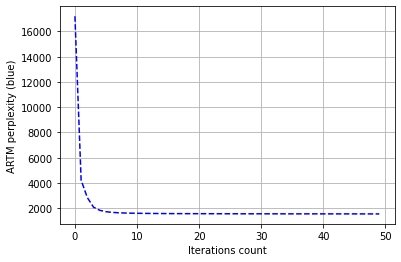

In [ ]:
print_measures(theme_mod)

##Сохранение модели в json формате

In [ ]:
import matplotlib.pyplot as plt
import copy

In [ ]:
themes_json = json.loads('{}')
top_tokens = theme_mod.score_tracker['TopTokensScore']

for topic_name in theme_mod.topic_names:
  themes_json[topic_name] = json.loads('{}')
  for (token, weight) in zip(top_tokens.last_tokens[topic_name], top_tokens.last_weights[topic_name]):
    themes_json[topic_name][token] = round(weight, 5)

with open('themes_json.json', 'w') as outfile:
  json.dump(themes_json, outfile)

In [ ]:
with open('themes_json.json') as json_file:
  data_json = json.load(json_file)

In [ ]:
data_json

{'topic_0': {'react': 0.00804,
  'js': 0.00781,
  'javascript': 0.00676,
  'html': 0.00631,
  'css': 0.00602,
  'typescript': 0.00556,
  'работа': 0.00493,
  'php': 0.00477,
  'опыт': 0.0041,
  'знание': 0.00387},
 'topic_1': {'работа': 0.00598,
  'опыт': 0.0055,
  'разработка': 0.00457,
  'казахстан': 0.00408,
  'android': 0.00403,
  'возможность': 0.00402,
  'знание': 0.00389,
  'видеть': 0.00368,
  'сербия': 0.00363,
  'армения': 0.00355},
 'topic_2': {'наш': 0.00368,
  'проект': 0.00355,
  'компания': 0.00354,
  'опыт': 0.0035,
  'работа': 0.00346,
  'разработка': 0.00331,
  'продукт': 0.00303,
  'понимание': 0.00285,
  'знание': 0.00279,
  'команда': 0.00267},
 'topic_3': {'работа': 0.0043,
  'опыт': 0.00399,
  'разработка': 0.00393,
  'наш': 0.00348,
  'команда': 0.00343,
  'компания': 0.00319,
  'разработчик': 0.00315,
  'проект': 0.00308,
  'продукт': 0.00288,
  'год': 0.0028},
 'topic_4': {'высокий': 0.00491,
  'знание': 0.00487,
  'работа': 0.00487,
  'технический': 0.00483,


#Визуализация

In [ ]:
import numpy as np

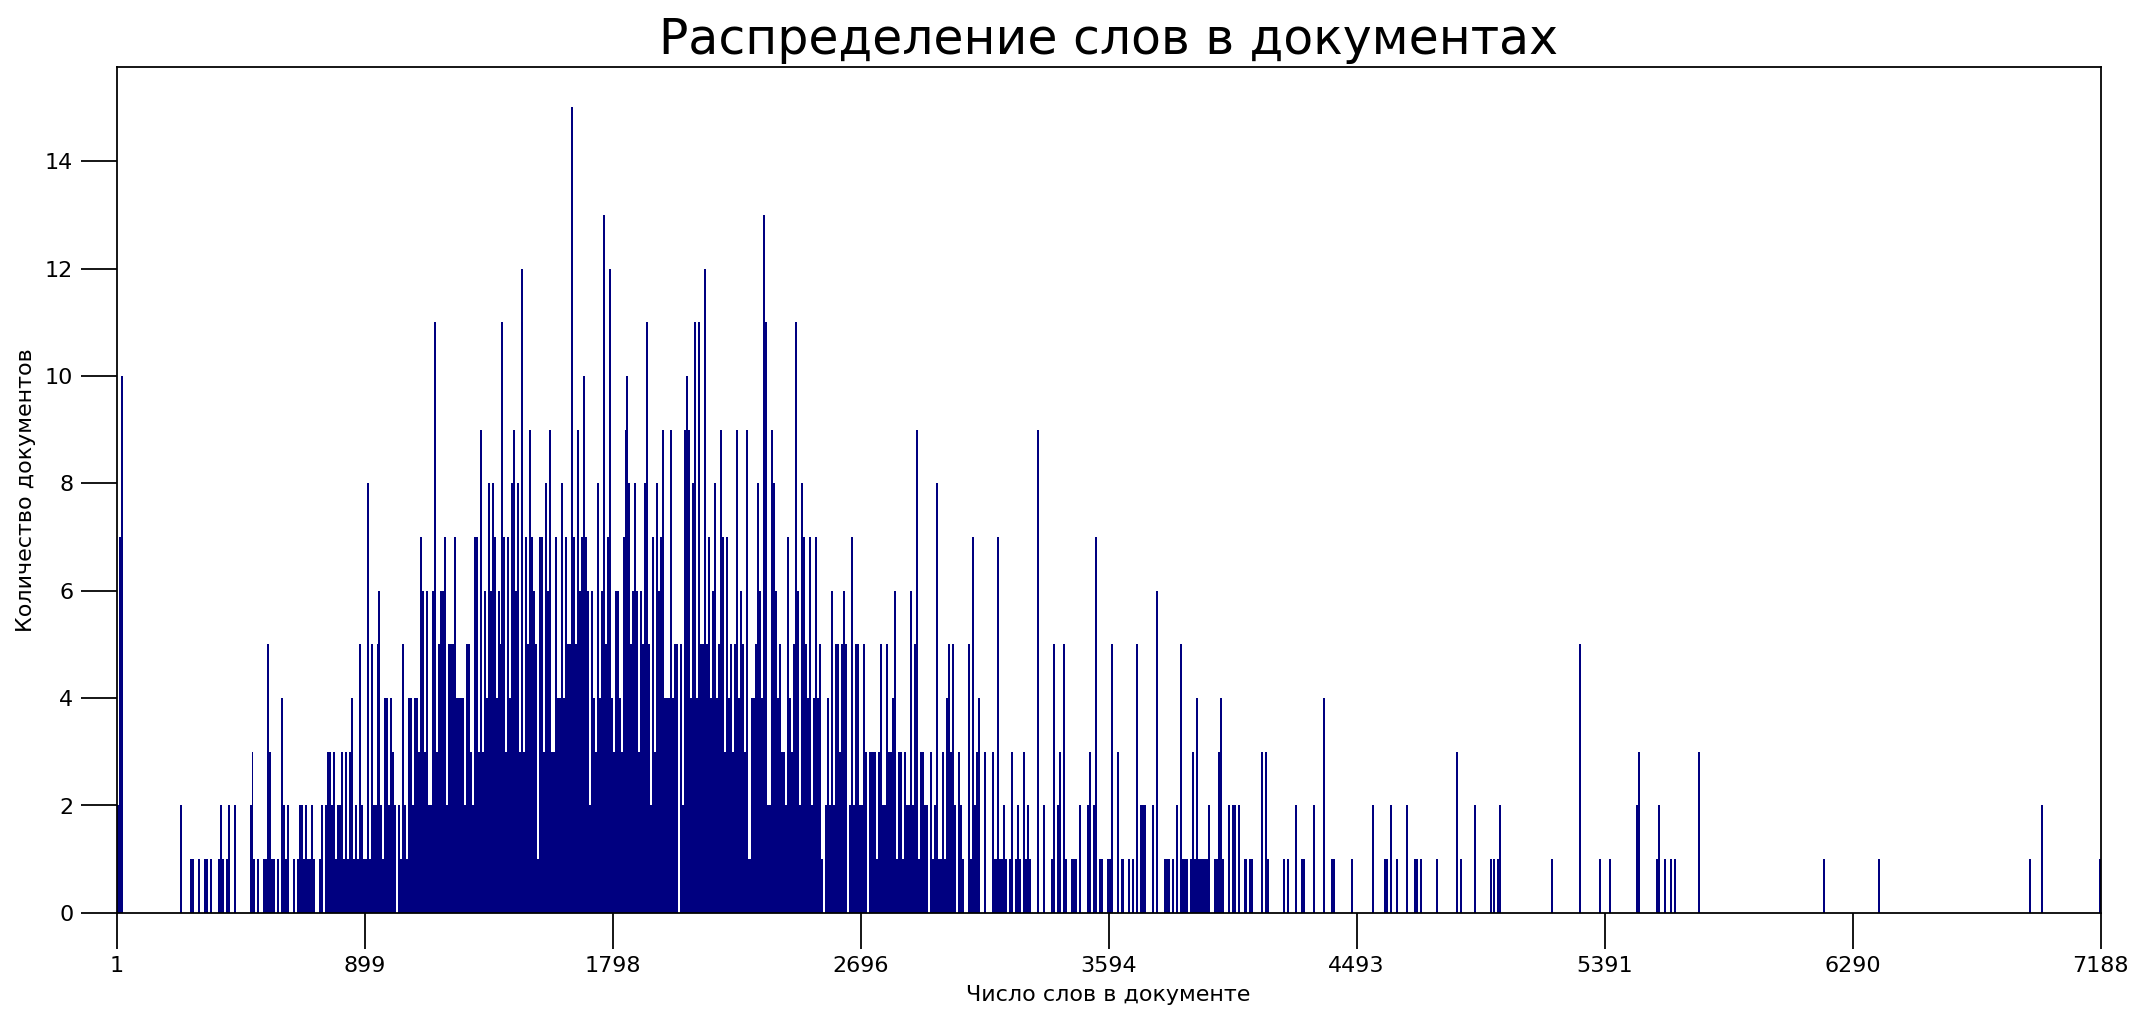

In [ ]:
doc_lens = [len(d) for d in data['prep_desc']]

plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')

plt.gca().set(xlim=(min(doc_lens), max(doc_lens)), ylabel='Количество документов', xlabel='Число слов в документе')
plt.tick_params(size=16)
plt.xticks(np.linspace(min(doc_lens), max(doc_lens),9))
plt.title('Распределение слов в документах', fontdict=dict(size=22))
plt.show()

In [ ]:
from wordcloud import WordCloud
import seaborn as sns
import random
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open('themes_json.json') as json_file:
  data_json = json.load(json_file)

In [ ]:
data_json

{'topic_0': {'react': 0.00804,
  'js': 0.00781,
  'javascript': 0.00676,
  'html': 0.00631,
  'css': 0.00602,
  'typescript': 0.00556,
  'работа': 0.00493,
  'php': 0.00477,
  'опыт': 0.0041,
  'знание': 0.00387},
 'topic_1': {'работа': 0.00598,
  'опыт': 0.0055,
  'разработка': 0.00457,
  'казахстан': 0.00408,
  'android': 0.00403,
  'возможность': 0.00402,
  'знание': 0.00389,
  'видеть': 0.00368,
  'сербия': 0.00363,
  'армения': 0.00355},
 'topic_2': {'наш': 0.00368,
  'проект': 0.00355,
  'компания': 0.00354,
  'опыт': 0.0035,
  'работа': 0.00346,
  'разработка': 0.00331,
  'продукт': 0.00303,
  'понимание': 0.00285,
  'знание': 0.00279,
  'команда': 0.00267},
 'topic_3': {'работа': 0.0043,
  'опыт': 0.00399,
  'разработка': 0.00393,
  'наш': 0.00348,
  'команда': 0.00343,
  'компания': 0.00319,
  'разработчик': 0.00315,
  'проект': 0.00308,
  'продукт': 0.00288,
  'год': 0.0028},
 'topic_4': {'высокий': 0.00491,
  'знание': 0.00487,
  'работа': 0.00487,
  'технический': 0.00483,


In [ ]:
terms_cloud = []
for theme in theme_mod.topic_names:
  text = "";
  text_raw = " ".join(theme_mod.score_tracker['TopTokensScore'].last_tokens[theme])
  terms_cloud.append(text_raw)

In [ ]:
wordcloud_1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[0])
wordcloud_2 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[2])
wordcloud_3 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[4])
wordcloud_4 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[7])
wordcloud_5 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[9])
wordcloud_6 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[10])
wordcloud_7 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[12])
wordcloud_8 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(terms_cloud[15])

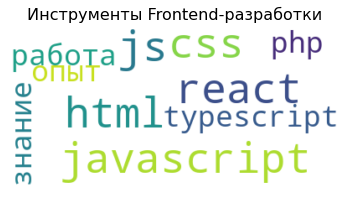

In [ ]:
plt.imshow(wordcloud_1, interpolation='bilinear', )
plt.gca().set_title('Инструменты Frontend-разработки', fontdict=dict(size=16))
plt.axis("off")
plt.show()

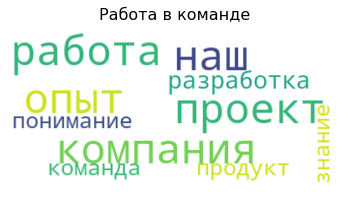

In [ ]:
plt.imshow(wordcloud_2, interpolation='bilinear', )
plt.gca().set_title('Работа в команде', fontdict=dict(size=16))
plt.axis("off")
plt.show()

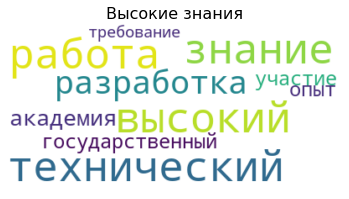

In [ ]:
plt.imshow(wordcloud_3, interpolation='bilinear', )
plt.gca().set_title('Высокие знания', fontdict=dict(size=16))
plt.axis("off")
plt.show()

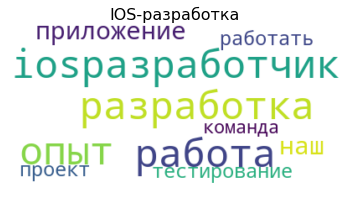

In [ ]:
plt.imshow(wordcloud_4, interpolation='bilinear', )
plt.gca().set_title('IOS-разработка', fontdict=dict(size=16))
plt.axis("off")
plt.show()

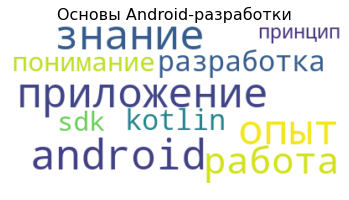

In [ ]:
plt.imshow(wordcloud_5, interpolation='bilinear', )
plt.gca().set_title('Основы Android-разработки', fontdict=dict(size=16))
plt.axis("off")
plt.show()

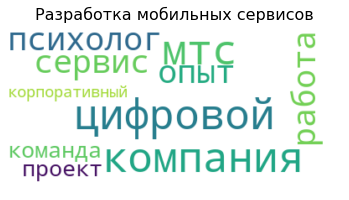

In [ ]:
plt.imshow(wordcloud_6, interpolation='bilinear', )
plt.gca().set_title('Разработка мобильных сервисов', fontdict=dict(size=16))
plt.axis("off")
plt.show()

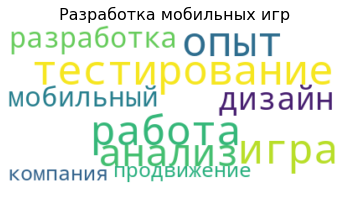

In [ ]:
plt.imshow(wordcloud_7, interpolation='bilinear', )
plt.gca().set_title('Разработка мобильных игр', fontdict=dict(size=16))
plt.axis("off")
plt.show()

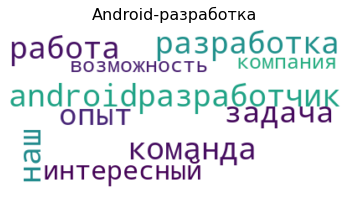

In [ ]:
plt.imshow(wordcloud_8, interpolation='bilinear', )
plt.gca().set_title('Android-разработка', fontdict=dict(size=16))
plt.axis("off")
plt.show()

In [ ]:
with open('themes_json.json') as json_file:
  themes_json = json.load(json_file)

In [ ]:
themes_json

{'topic_0': {'react': 0.00804,
  'js': 0.00781,
  'javascript': 0.00676,
  'html': 0.00631,
  'css': 0.00602,
  'typescript': 0.00556,
  'работа': 0.00493,
  'php': 0.00477,
  'опыт': 0.0041,
  'знание': 0.00387},
 'topic_1': {'работа': 0.00598,
  'опыт': 0.0055,
  'разработка': 0.00457,
  'казахстан': 0.00408,
  'android': 0.00403,
  'возможность': 0.00402,
  'знание': 0.00389,
  'видеть': 0.00368,
  'сербия': 0.00363,
  'армения': 0.00355},
 'topic_2': {'наш': 0.00368,
  'проект': 0.00355,
  'компания': 0.00354,
  'опыт': 0.0035,
  'работа': 0.00346,
  'разработка': 0.00331,
  'продукт': 0.00303,
  'понимание': 0.00285,
  'знание': 0.00279,
  'команда': 0.00267},
 'topic_3': {'работа': 0.0043,
  'опыт': 0.00399,
  'разработка': 0.00393,
  'наш': 0.00348,
  'команда': 0.00343,
  'компания': 0.00319,
  'разработчик': 0.00315,
  'проект': 0.00308,
  'продукт': 0.00288,
  'год': 0.0028},
 'topic_4': {'высокий': 0.00491,
  'знание': 0.00487,
  'работа': 0.00487,
  'технический': 0.00483,


In [ ]:
topic_names_new = list(themes_json.keys())

terms_name_new = list()
weight_terms_new = list()

for name_new in topic_names_new:
  terms_name_new.append(list(themes_json[name_new]))
  weight_terms_new.append(list(themes_json[name_new].values()))

In [ ]:
colors = list()
for j in range(len(topic_names_new)):
  colors.append("#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)]))

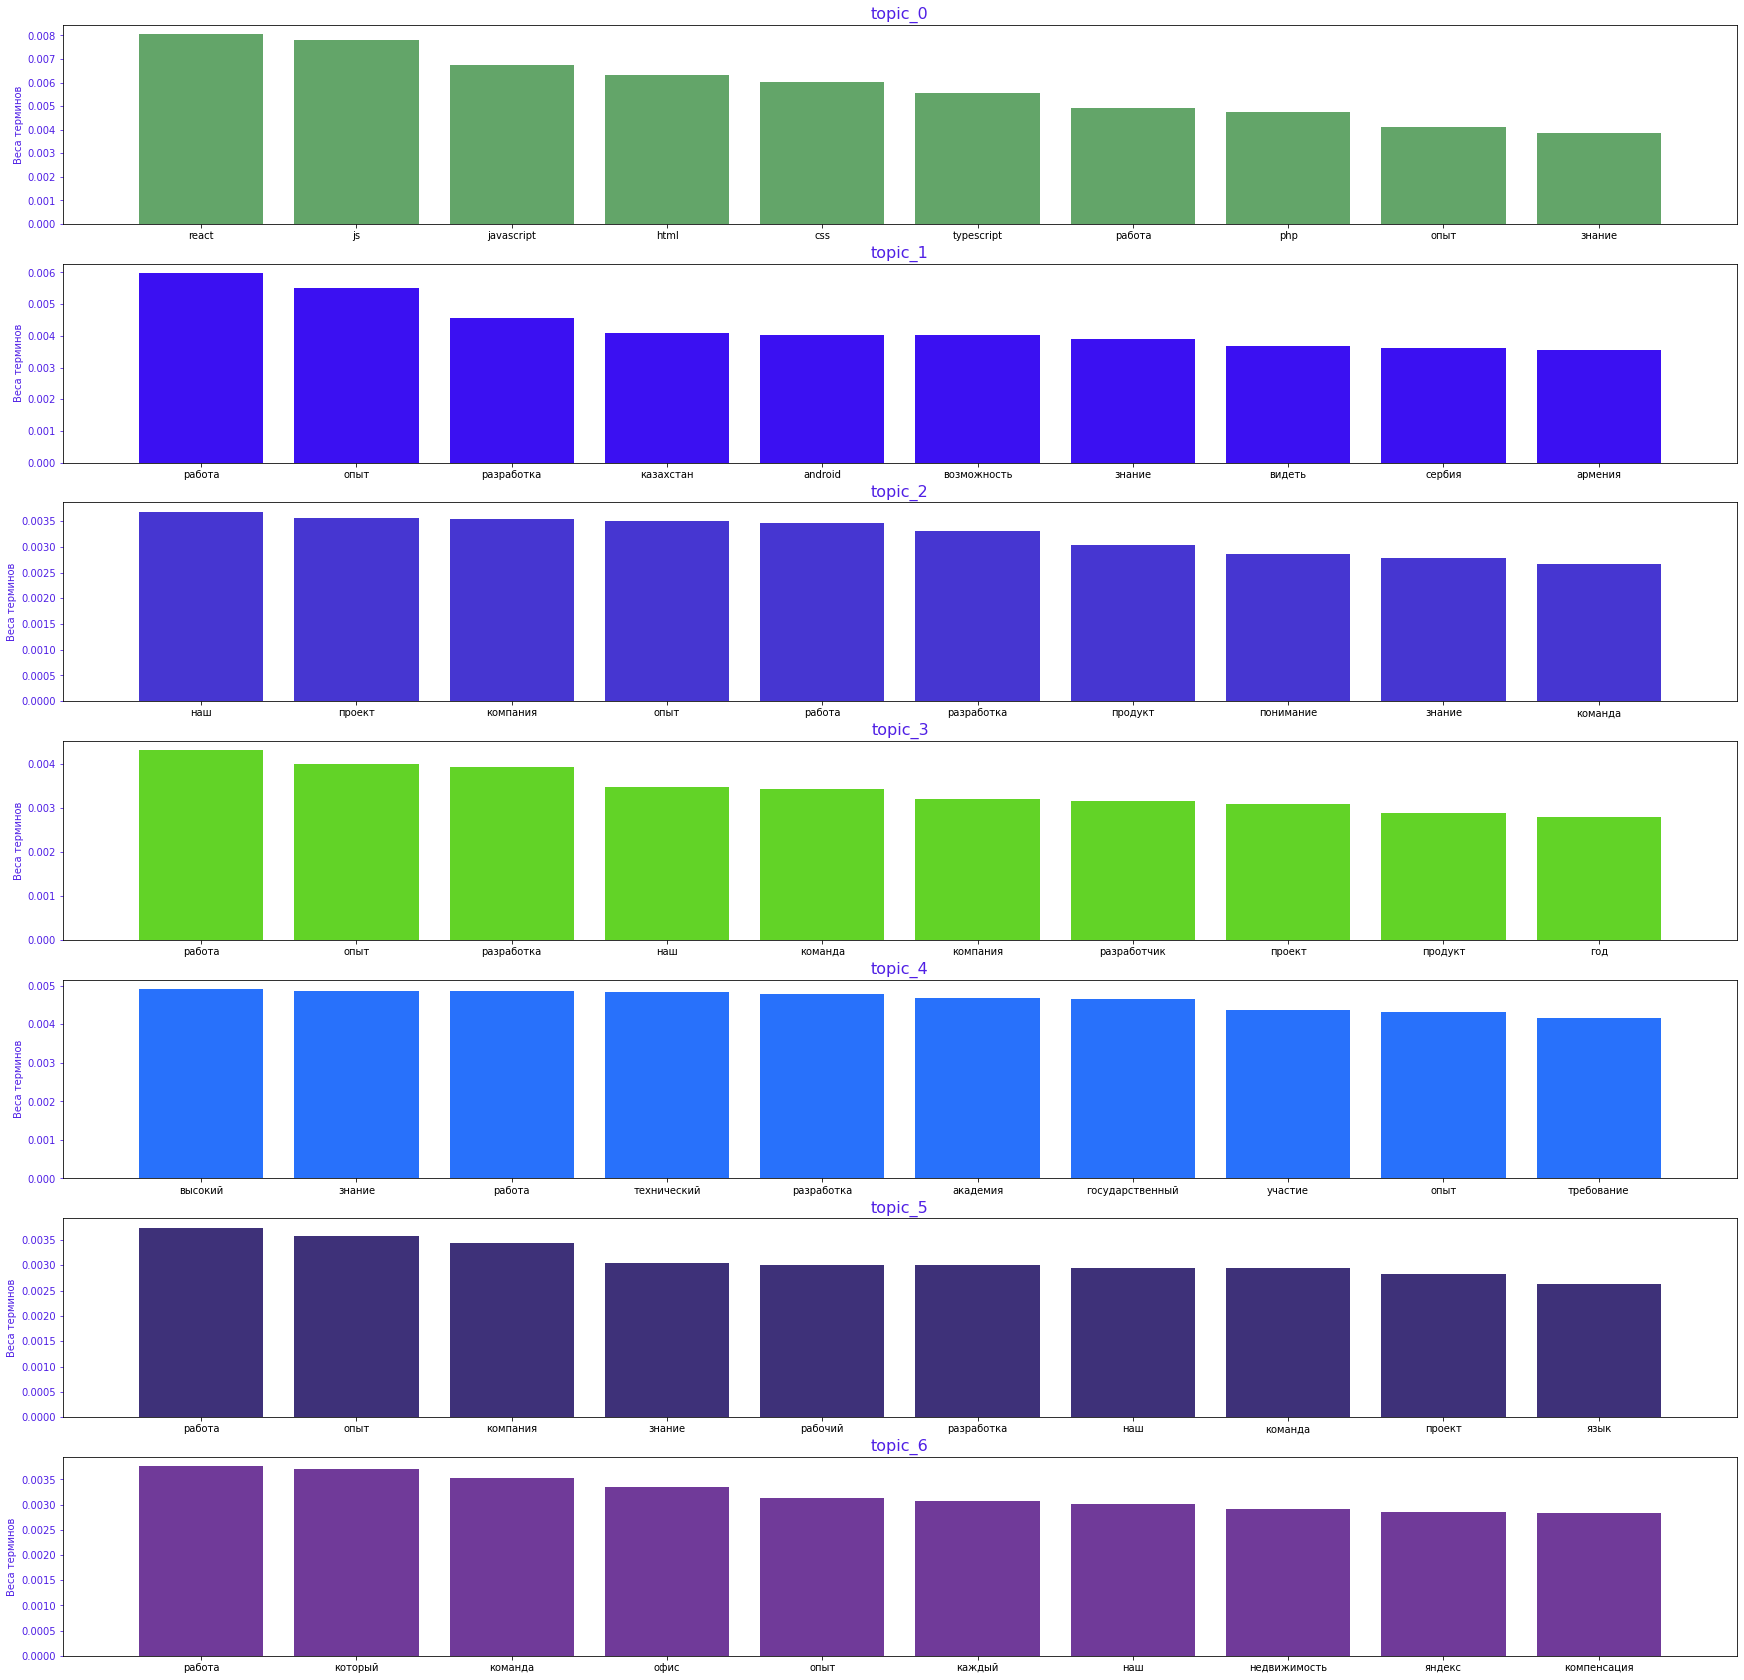

In [ ]:
fig, axes = plt.subplots(7, 1, figsize=(30, 30))

for i, ax in enumerate(axes.flatten()):
    words = terms_name_new[i]
    weights = weight_terms_new[i]
    ax.bar(words, weights, color=colors[i])
    ax.tick_params(axis='y', labelcolor='#5020E5', color='#5020E5')
    ax.set_ylabel('Веса терминов', color='#5020E5')
    ax.set_title(topic_names_new[i], fontdict=dict(size=16, color='#5020E5'))
plt.show()